In [1]:
import nltk
import pandas as pd
from nltk.corpus import stopwords
import torch
import re
from datasets import Dataset
from transformers import AutoTokenizer
from datasets import Dataset
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import numpy as np
from torch import nn
import torch.optim as optim
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')
nltk.download('wordnet')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from catboost import CatBoostClassifier
from sklearn.utils import compute_sample_weight
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, make_scorer
from wordcloud import WordCloud, STOPWORDS
import spacy
import matplotlib.pyplot as plt
import torchmetrics
from torchmetrics import F1Score
from torch.nn.utils.rnn import pad_sequence
import spacy
from nltk.tokenize import word_tokenize
from spacy.lang.ru.examples import sentences

%matplotlib inline


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\79169\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\79169\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\79169\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\79169\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


 Вспомогательные функции

In [6]:
def get_corpus(data):
    corpus = []
    for phrase in data:
        for word in phrase.split():
            corpus.append(word)
    return corpus


def str_corpus(corpus):
    str_corpus = ''
    for i in corpus:
        str_corpus += ' ' + i
    str_corpus = str_corpus.strip()
    return str_corpus


def get_wordCloud(corpus):
    wordCloud = WordCloud(background_color='white',
                          stopwords=STOPWORDS,
                          width=3000,
                          height=2500,
                          max_words=200,
                          random_state=42).generate(str_corpus(corpus))
    return wordCloud

def lemmatize_and_clean_text_eng(text):
    # Очищаем текст от пунктуации и цифр
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip().lower()  # Приводим текст к нижнему регистру
    tokens = word_tokenize(text)

        
    # Лемматизация каждого слова с исключением стоп-слов
    lemmas = [wordnet_lemmatizer.lemmatize(token) for token in tokens if token not in stopwords_set]
    
    return ' '.join(lemmas)


def lemmatize_and_clean_text_rus(text):
    text = re.sub(r'[^\w\s]', ' ', text)  # Удаляем пунктуацию
    text = re.sub(r'\d', ' ', text)  # Удаляем цифры
    text = re.sub(r'[A-Za-z]', ' ', text)  # Удаляем латинские буквы
    text = re.sub(r'\s+', ' ', text)  # Заменяем один или более пробелов на один пробел
    text = text.strip()  # Убираем пробелы в начале и конце строки

    # Лемматизация с помощью SpaCy и удаление стоп слов
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and not token.is_space and token.text in nlp.vocab]
    return ' '.join(lemmas)


Загружаем данные

In [3]:
dx1 = pd.read_csv(r'D:\WORK\пет проекты и портфолио\NLP\russian-troll-tweets-master\russian-troll-tweets-master\IRAhandle_tweets_1.csv', low_memory=False)
dx2 = pd.read_csv(r'D:\WORK\пет проекты и портфолио\NLP\russian-troll-tweets-master\russian-troll-tweets-master\IRAhandle_tweets_2.csv', low_memory=False)
dx3 = pd.read_csv(r'D:\WORK\пет проекты и портфолио\NLP\russian-troll-tweets-master\russian-troll-tweets-master\IRAhandle_tweets_3.csv', low_memory=False)
dx4 = pd.read_csv(r'D:\WORK\пет проекты и портфолио\NLP\russian-troll-tweets-master\russian-troll-tweets-master\IRAhandle_tweets_4.csv', low_memory=False)
dx5 = pd.read_csv(r'D:\WORK\пет проекты и портфолио\NLP\russian-troll-tweets-master\russian-troll-tweets-master\IRAhandle_tweets_5.csv', low_memory=False)
dx6 = pd.read_csv(r'D:\WORK\пет проекты и портфолио\NLP\russian-troll-tweets-master\russian-troll-tweets-master\IRAhandle_tweets_6.csv', low_memory=False)
dx7 = pd.read_csv(r'D:\WORK\пет проекты и портфолио\NLP\russian-troll-tweets-master\russian-troll-tweets-master\IRAhandle_tweets_7.csv', low_memory=False)
dx8 = pd.read_csv(r'D:\WORK\пет проекты и портфолио\NLP\russian-troll-tweets-master\russian-troll-tweets-master\IRAhandle_tweets_8.csv', low_memory=False)
dx9 = pd.read_csv(r'D:\WORK\пет проекты и портфолио\NLP\russian-troll-tweets-master\russian-troll-tweets-master\IRAhandle_tweets_9.csv', low_memory=False)
dx10 = pd.read_csv(r'D:\WORK\пет проекты и портфолио\NLP\russian-troll-tweets-master\russian-troll-tweets-master\IRAhandle_tweets_10.csv', low_memory=False)
dx11 = pd.read_csv(r'D:\WORK\пет проекты и портфолио\NLP\russian-troll-tweets-master\russian-troll-tweets-master\IRAhandle_tweets_11.csv', low_memory=False)
dx12 = pd.read_csv(r'D:\WORK\пет проекты и портфолио\NLP\russian-troll-tweets-master\russian-troll-tweets-master\IRAhandle_tweets_12.csv', low_memory=False)
dx13 = pd.read_csv(r'D:\WORK\пет проекты и портфолио\NLP\russian-troll-tweets-master\russian-troll-tweets-master\IRAhandle_tweets_13.csv', low_memory=False)

Краткое описание


external_author_id-An author account ID from Twitter

author-The handle sending the tweet

content-The text of the tweet

region-A region classification, as determined by Social Studio

language-The language of the tweet

publish_date-The date and time the tweet was sent

harvested_date-The date and time the tweet was collected by Social Studio

following-The number of accounts the handle was following at the time of the tweet

followers-The number of followers the handle had at the time of the tweet

updates-The number of “update actions” on the account that authored the tweet, including tweets, retweets and likes

post_type-Indicates if the tweet was a retweet or a quote-tweet

account_type-Specific account theme, as coded by Linvill and Warren

retweet-A binary indicator of whether or not the tweet is a retweet

account_category-General account theme, as coded by Linvill and Warren

new_june_2018-A binary indicator of whether the handle was newly listed in June 2018

alt_external_id-Reconstruction of author account ID from Twitter, derived from article_url variable and the first list provided to Congress

tweet_id-Unique id assigned by twitter to each status update, derived from article_url

article_url-Link to original tweet. Now redirects to "Account Suspended" page

tco1_step1-First redirect for the first http(s)://t.co/ link in a tweet, if it exists

tco2_step1-First redirect for the second http(s)://t.co/ link in a tweet, if it exists

tco3_step1-First redirect for the third http(s)://t.co/ link in a tweet, if it exists

In [4]:
df = pd.concat([dx1, dx2, dx3, dx4, dx5, dx6, dx7, dx8, dx9, dx10, dx11, dx12], ignore_index=True)
df.head(100)

,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,...,account_type,retweet,account_category,new_june_2018,alt_external_id,tweet_id,article_url,tco1_step1,tco2_step1,tco3_step1
0,906000000000000000,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,10/1/2017 19:58,10/1/2017 19:59,1052,9636,253,...,Right,0,RightTroll,0,905874659358453760,914580356430536707,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/914580356430...,NaN,NaN
1,906000000000000000,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,10/1/2017 22:43,10/1/2017 22:43,1054,9637,254,...,Right,0,RightTroll,0,905874659358453760,914621840496189440,http://twitter.com/905874659358453760/statuses...,https://twitter.com/damienwoody/status/9145685...,NaN,NaN
2,906000000000000000,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,10/1/2017 22:50,10/1/2017 22:51,1054,9637,255,...,Right,1,RightTroll,0,905874659358453760,914623490375979008,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/913231923715...,NaN,NaN
3,906000000000000000,10_GOP,JUST IN: President Trump dedicates Presidents ...,Unknown,English,10/1/2017 23:52,10/1/2017 23:52,1062,9642,256,...,Right,0,RightTroll,0,905874659358453760,914639143690555392,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/914639143690...,NaN,NaN
4,906000000000000000,10_GOP,"19,000 RESPECTING our National Anthem! #StandF...",Unknown,English,10/1/2017 2:13,10/1/2017 2:13,1050,9645,246,...,Right,1,RightTroll,0,905874659358453760,914312219952861184,http://twitter.com/905874659358453760/statuses...,https://twitter.com/realDonaldTrump/status/914...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,906000000000000000,10_GOP,Guns don't kill people. People kill people. h...,Unknown,English,10/4/2017 23:49,10/4/2017 23:49,1070,10115,287,...,Right,1,RightTroll,0,905874659358453760,915725584461910016,http://twitter.com/905874659358453760/statuses...,https://twitter.com/jk_rowling/status/91496191...,NaN,NaN
96,906000000000000000,10_GOP,"Las Vegas victim meets Trump, stands up on wou...",Unknown,English,10/5/2017 0:51,10/5/2017 0:51,1070,10119,288,...,Right,0,RightTroll,0,905874659358453760,915741126182735873,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/915741126182...,NaN,NaN
97,906000000000000000,10_GOP,50+ dead and 500+ injured in Las Vegas. Where'...,Unknown,English,10/5/2017 1:39,10/5/2017 1:39,1070,10129,289,...,Right,0,RightTroll,0,905874659358453760,915753349554823168,http://twitter.com/905874659358453760/statuses...,NaN,NaN,NaN
98,906000000000000000,10_GOP,You won't see this picture on CNN! https://t.c...,Unknown,English,10/5/2017 21:08,10/5/2017 21:08,1070,10229,291,...,Right,0,RightTroll,0,905874659358453760,916047546518208512,http://twitter.com/905874659358453760/statuses...,https://twitter.com/10_gop/status/916047546518...,NaN,NaN


Отбросим часть ненужных столбцов

In [5]:
dff = df.drop(['external_author_id', 'author','tweet_id','alt_external_id','article_url','tco1_step1','tco2_step1','tco3_step1'], axis=1)
dff

,content,region,language,publish_date,harvested_date,following,followers,updates,post_type,account_type,retweet,account_category,new_june_2018
0,"""We have a sitting Democrat US Senator on tria...",Unknown,English,10/1/2017 19:58,10/1/2017 19:59,1052,9636,253,NaN,Right,0,RightTroll,0
1,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,10/1/2017 22:43,10/1/2017 22:43,1054,9637,254,NaN,Right,0,RightTroll,0
2,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,10/1/2017 22:50,10/1/2017 22:51,1054,9637,255,RETWEET,Right,1,RightTroll,0
3,JUST IN: President Trump dedicates Presidents ...,Unknown,English,10/1/2017 23:52,10/1/2017 23:52,1062,9642,256,NaN,Right,0,RightTroll,0
4,"19,000 RESPECTING our National Anthem! #StandF...",Unknown,English,10/1/2017 2:13,10/1/2017 2:13,1050,9645,246,RETWEET,Right,1,RightTroll,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925308,Нет слов... https://t.co/Q11oaKiJIS,Unknown,Russian,9/14/2015 17:09,9/14/2015 17:09,3559,22633,13212,QUOTE_TWEET,Russian,1,NonEnglish,0
2925309,'@VRSoloviev ГУМВД: уголовное дело возбуждено ...,Unknown,Russian,9/14/2015 17:57,9/14/2015 17:57,3559,22633,13217,NaN,Russian,0,NonEnglish,0
2925310,Великое переселение народов продолжается. Неда...,Unknown,Russian,9/14/2015 6:25,9/14/2015 8:42,3563,22629,13192,NaN,Russian,0,NonEnglish,0
2925311,Порошенко вновь просит США поставить вооружени...,Unknown,Russian,9/14/2015 6:55,9/14/2015 6:58,3563,22623,13183,NaN,Russian,0,NonEnglish,0


Посмотрим на целевые классы для классификации

In [32]:
dff['account_category'].unique()

array(['RightTroll', 'NonEnglish', 'Fearmonger', 'LeftTroll', 'Unknown',
       'HashtagGamer', 'NewsFeed', 'Commercial'], dtype=object)

Количество языков, на котором написаны твитты

In [33]:
dff['language'].unique()

array(['English', 'Russian', 'Serbian', 'Ukrainian', 'Tagalog (Filipino)',
       'Albanian', 'Italian', 'Romanian', 'Spanish', 'Catalan', 'German',
       'Estonian', 'French', 'Norwegian', 'Vietnamese', 'Dutch', 'Arabic',
       'Uzbek', 'Bulgarian', 'Macedonian', 'Farsi (Persian)', 'Turkish',
       'LANGUAGE UNDEFINED', 'Czech', 'Somali', 'Lithuanian', 'Croatian',
       'Slovak', 'Icelandic', 'Slovenian', 'Japanese', 'Indonesian',
       'Pushto', 'Hungarian', 'Finnish', 'Latvian', 'Portuguese',
       'Danish', 'Swedish', 'Malay', 'Polish', 'Korean', 'Hebrew', 'Urdu',
       'Kurdish', 'Hindi', 'Greek', 'Simplified Chinese', 'Thai',
       'Bengali', 'Traditional Chinese', 'Gujarati', 'Kannada', 'Tamil',
       'Telugu', 'Malayalam'], dtype=object)

Возьмем только русский и английский язык (большинство твиттов)

In [6]:
d_eng = dff[dff['language']=='English']
d_rus = dff[dff['language']=='Russian']
d_rus

,content,region,language,publish_date,harvested_date,following,followers,updates,post_type,account_type,retweet,account_category,new_june_2018
372,Причина #67 Мутко: «Зенит-Арене» для адаптации...,Unknown,Russian,1/19/2017 13:07,1/19/2017 13:07,6311,6313,1806,NaN,Russian,0,NonEnglish,0
373,Причина #70 Житель Самары умер в очереди в пол...,Unknown,Russian,1/22/2017 12:37,4/5/2017 7:17,1580,6298,1869,NaN,Russian,0,NonEnglish,0
374,Причина #74 Президентский советник предложил о...,Unknown,Russian,1/26/2017 15:39,1/26/2017 15:40,6305,6312,1813,NaN,Russian,0,NonEnglish,0
375,Причина #75 Казаков благословили на защиту инт...,Unknown,Russian,1/27/2017 13:23,1/27/2017 13:23,6304,6311,1814,NaN,Russian,0,NonEnglish,0
376,Причина #77 В Кстово полицейские сломали женщи...,Unknown,Russian,1/29/2017 11:07,1/29/2017 11:30,6306,6308,1816,NaN,Russian,0,NonEnglish,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925308,Нет слов... https://t.co/Q11oaKiJIS,Unknown,Russian,9/14/2015 17:09,9/14/2015 17:09,3559,22633,13212,QUOTE_TWEET,Russian,1,NonEnglish,0
2925309,'@VRSoloviev ГУМВД: уголовное дело возбуждено ...,Unknown,Russian,9/14/2015 17:57,9/14/2015 17:57,3559,22633,13217,NaN,Russian,0,NonEnglish,0
2925310,Великое переселение народов продолжается. Неда...,Unknown,Russian,9/14/2015 6:25,9/14/2015 8:42,3563,22629,13192,NaN,Russian,0,NonEnglish,0
2925311,Порошенко вновь просит США поставить вооружени...,Unknown,Russian,9/14/2015 6:55,9/14/2015 6:58,3563,22623,13183,NaN,Russian,0,NonEnglish,0


Отбрасываем оставшиеся лишнние столбцы

In [7]:
d_eng = d_eng.drop(['language','region','publish_date','harvested_date','following','followers','updates','post_type','account_type','retweet','new_june_2018'], axis=1)
d_rus = d_rus.drop(['language','region','publish_date','harvested_date','following','followers','updates','post_type','account_type','retweet','new_june_2018'], axis=1)
d_eng

,content,account_category
0,"""We have a sitting Democrat US Senator on tria...",RightTroll
1,Marshawn Lynch arrives to game in anti-Trump s...,RightTroll
2,Daughter of fallen Navy Sailor delivers powerf...,RightTroll
3,JUST IN: President Trump dedicates Presidents ...,RightTroll
4,"19,000 RESPECTING our National Anthem! #StandF...",RightTroll
...,...,...
2925022,'@realDonaldTrump @benfergusonshow @CNN Trump ...,NonEnglish
2925052,'@KadirovRussia This Tweet is unavailable.',NonEnglish
2925067,"'@HillaryClinton don't worry be happy, Hillary'",NonEnglish
2925088,'@realDonaldTrump Bush is a rino',NonEnglish


Приводим к нижнему регистру и чистим английскую часть датасета

In [8]:
d_eng['content'] = d_eng['content'].astype(str)

In [9]:
nltk.download('punkt_tab')
stopwords_set = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()
d_eng['content'] = d_eng['content'].apply(lemmatize_and_clean_text_eng)
d_eng

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\79169\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,content,account_category
0,sitting democrat u senator trial corruption ba...,RightTroll
1,marshawn lynch arrives game anti trump shirt j...,RightTroll
2,daughter fallen navy sailor delivers powerful ...,RightTroll
3,president trump dedicates president cup golf t...,RightTroll
4,respecting national anthem standforouranthem h...,RightTroll
...,...,...
2925022,realdonaldtrump benfergusonshow cnn trump deni...,NonEnglish
2925052,kadirovrussia tweet unavailable,NonEnglish
2925067,hillaryclinton worry happy hillary,NonEnglish
2925088,realdonaldtrump bush rino,NonEnglish


In [ ]:
!python -m spacy download ru_core_news_sm

Подготавливаемся к лемматизации русского текста

In [10]:

nlp = spacy.load('ru_core_news_sm')
russian_stopwords = stopwords.words('russian')

In [11]:
d_rus['content'] = d_rus['content'].astype(str)
d_rus['content'] = d_rus['content'].apply(lemmatize_and_clean_text_rus)
d_rus

,content,account_category
372,причина мутко зенит арена адаптация чм потребо...,NonEnglish
373,причина житель самара умереть очередь поликлиника,NonEnglish
374,причина президентский советник предложить огра...,NonEnglish
375,причина казак благословить защита интернет про...,NonEnglish
376,причина кстово полицейский сломать женщина лиц...,NonEnglish
...,...,...
2925308,слово,NonEnglish
2925309,гумвд уголовный дело возбудить факт погром выс...,NonEnglish
2925310,великий переселение народ продолжаться мюнхен ...,NonEnglish
2925311,порошенко просить сша поставить вооружение укр...,NonEnglish


Посмотрим, какие слова чаще всего фигурировали в ру и анг сегментах твиттера

In [12]:
corpus = get_corpus(d_eng['content'])


In [13]:
corpus_ru = get_corpus(d_rus['content'])

In [14]:
proc = get_wordCloud(corpus)

In [15]:
proc_ru = get_wordCloud(corpus_ru)

<Axes: >

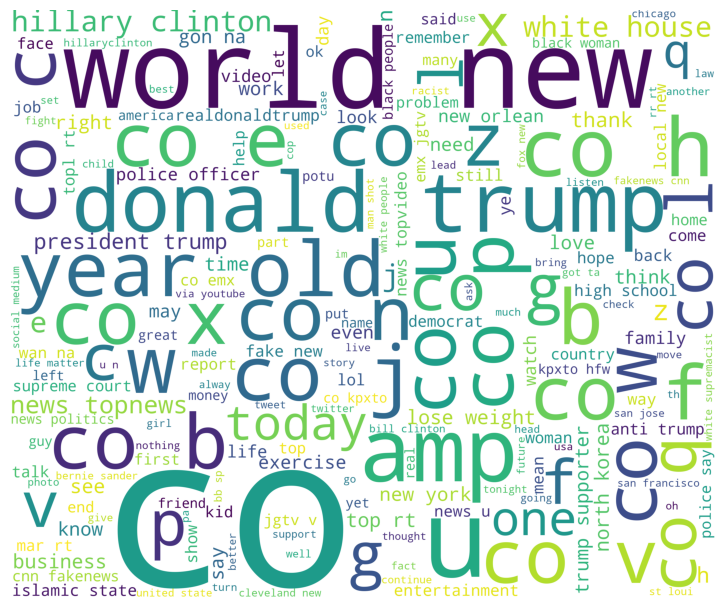

In [16]:
fig = plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.imshow(proc)
plt.axis('off')
plt.subplot(1,2,1)

<Axes: >

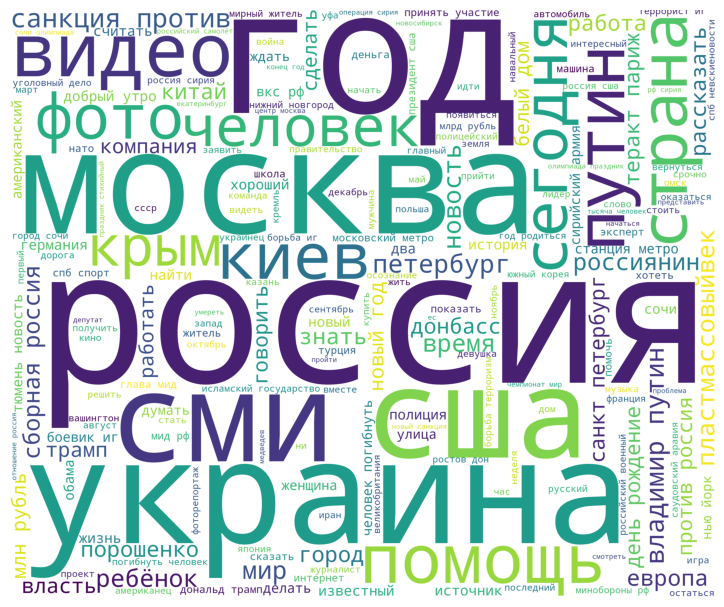

In [17]:
fig = plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.imshow(proc_ru)
plt.axis('off')
plt.subplot(1,2,1)

Посмотрим на распределение классов

Собираем английский и русский датасет в 1

In [18]:
twitts = pd.concat([d_eng, d_rus])
twitts

,content,account_category
0,sitting democrat u senator trial corruption ba...,RightTroll
1,marshawn lynch arrives game anti trump shirt j...,RightTroll
2,daughter fallen navy sailor delivers powerful ...,RightTroll
3,president trump dedicates president cup golf t...,RightTroll
4,respecting national anthem standforouranthem h...,RightTroll
...,...,...
2925308,слово,NonEnglish
2925309,гумвд уголовный дело возбудить факт погром выс...,NonEnglish
2925310,великий переселение народ продолжаться мюнхен ...,NonEnglish
2925311,порошенко просить сша поставить вооружение укр...,NonEnglish


In [65]:
twitts.to_csv('twitts_old.csv', index=False)

In [19]:
twitts.groupby('account_category').size()

account_category
Commercial      112589
Fearmonger       10861
HashtagGamer    236113
LeftTroll       416694
NewsFeed        596608
NonEnglish      629073
RightTroll      699435
Unknown           6946
dtype: int64

In [20]:
twitts = twitts.reset_index(drop=True)
twitts

,content,account_category
0,sitting democrat u senator trial corruption ba...,RightTroll
1,marshawn lynch arrives game anti trump shirt j...,RightTroll
2,daughter fallen navy sailor delivers powerful ...,RightTroll
3,president trump dedicates president cup golf t...,RightTroll
4,respecting national anthem standforouranthem h...,RightTroll
...,...,...
2708314,слово,NonEnglish
2708315,гумвд уголовный дело возбудить факт погром выс...,NonEnglish
2708316,великий переселение народ продолжаться мюнхен ...,NonEnglish
2708317,порошенко просить сша поставить вооружение укр...,NonEnglish


1 Для baseline модели возьмем градиентный бустинг и посмотрим

In [21]:
X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(twitts['content'], twitts['account_category'] , test_size=0.2, random_state=42)

Так как у нас явный дисбаланс классов, посчитаем для каждого класса свой вес

In [22]:
sample_weights_eng = compute_sample_weight(class_weight='balanced', y=y_test_eng)


In [23]:
cat_eng = Pipeline([('tfidf', TfidfVectorizer()),('cat',CatBoostClassifier(
    auto_class_weights='Balanced',
    random_state=10,
    task_type='CPU',
))])

In [24]:
cat_eng.fit(X_train_eng, y_train_eng)

Learning rate set to 0.117071
0:	learn: 1.9335385	total: 13.8s	remaining: 3h 49m 25s
1:	learn: 1.8476371	total: 25.8s	remaining: 3h 34m 45s
2:	learn: 1.7831234	total: 37.7s	remaining: 3h 28m 46s
3:	learn: 1.7378885	total: 49.8s	remaining: 3h 26m 51s
4:	learn: 1.6941860	total: 1m 1s	remaining: 3h 23m 25s
5:	learn: 1.6637291	total: 1m 12s	remaining: 3h 19m 51s
6:	learn: 1.6364698	total: 1m 24s	remaining: 3h 20m 15s
7:	learn: 1.6190729	total: 1m 33s	remaining: 3h 12m 35s
8:	learn: 1.5956559	total: 1m 44s	remaining: 3h 11m 5s
9:	learn: 1.5777995	total: 1m 56s	remaining: 3h 12m 55s
10:	learn: 1.5649312	total: 2m 4s	remaining: 3h 6m 42s
11:	learn: 1.5496531	total: 2m 15s	remaining: 3h 6m 7s
12:	learn: 1.5386220	total: 2m 24s	remaining: 3h 2m 29s
13:	learn: 1.5247171	total: 2m 33s	remaining: 3h 23s
14:	learn: 1.5178599	total: 2m 41s	remaining: 2h 56m 23s
15:	learn: 1.5094241	total: 2m 48s	remaining: 2h 52m 48s
16:	learn: 1.5023709	total: 2m 55s	remaining: 2h 49m 16s
17:	learn: 1.4916355	total

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('cat',
                 <catboost.core.CatBoostClassifier object at 0x0000018FCF2BE4E0>)])

In [25]:
predicted_cat = cat_eng.predict(X_test_eng)

In [26]:
print(classification_report(predicted_cat,y_test_eng, sample_weight=sample_weights_eng))

              precision    recall  f1-score   support

  Commercial       0.68      0.93      0.78 49832.47629106124
  Fearmonger       0.69      0.90      0.78 51756.018445406124
HashtagGamer       0.67      0.77      0.71 58964.793790660704
   LeftTroll       0.46      0.43      0.45 72152.89427637913
    NewsFeed       0.85      0.54      0.66 107132.80559010725
  NonEnglish       0.96      0.65      0.77 100639.48151446856
  RightTroll       0.49      0.70      0.58 47209.3341882858
     Unknown       0.41      0.52      0.46 53976.19590359759

    accuracy                           0.65 541663.9999999664
   macro avg       0.65      0.68      0.65 541663.9999999664
weighted avg       0.69      0.65      0.65 541663.9999999664



##2 Возьмем кастомную обычную нейронную сетку на LSTM

In [27]:
all_eng = ' '.join(twitts['content']).split()



In [28]:

unique_words_eng = sorted(set(all_eng))


Преобразуем классы 

In [2]:
twitts = pd.read_csv('twitts_old.csv')

In [3]:
labels_eng = twitts['account_category'].values.tolist()


In [4]:
 twitts['content'] = twitts['content'].astype(str)

In [5]:
all_eng = ' '.join(twitts['content']).split()

In [6]:

encoder = LabelEncoder()
labels_eng = encoder.fit_transform(labels_eng)


In [7]:
unique_words_eng = sorted(set(all_eng))

In [8]:

word_to_index_eng = {word: index for index, word in enumerate(unique_words_eng, start=1)}


In [15]:
len(word_to_index_eng)

2294965

In [9]:

def text_to_sequence(text, word_to_index):
    return [word_to_index.get(word, 0) for word in text.split()] 

sequences_eng = [text_to_sequence(text, word_to_index_eng) for text in twitts['content']]


In [10]:
device = torch.device("cuda")
print(f"Using {device} device")


Using cuda device


In [11]:
sequences_eng_train, sequences_eng_test, labels_eng_train, labels_eng_test = train_test_split(
    sequences_eng, labels_eng , test_size=0.2, random_state=42)


In [12]:
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

In [13]:
def collate_fn(batch):
    sequences, labels = zip(*batch)
    sequences = [torch.tensor(s, dtype=torch.long) for s in sequences]
    labels = torch.tensor(labels, dtype=torch.long)
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=0)
    labels = torch.tensor(labels, dtype=torch.long)
    return sequences_padded, labels

In [14]:
train_dataset_eng = TextDataset(sequences_eng_train, labels_eng_train)
test_dataset_eng = TextDataset(sequences_eng_test, labels_eng_test)


In [15]:
train_loader_eng = DataLoader(train_dataset_eng, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader_eng = DataLoader(test_dataset_eng, batch_size=32, shuffle=False, collate_fn=collate_fn)


In [16]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout_rate):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

        
        self.batchnorm = nn.BatchNorm1d(hidden_dim)

        
        self.dropout = nn.Dropout(dropout_rate)

        
        self.fc1 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.fc2 = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, sequences):
        embedded = self.embedding(sequences)
        lstm_out, _ = self.lstm(embedded)

        # Применяем BatchNorm и Dropout к последнему скрытому состоянию
        lstm_out = self.batchnorm(lstm_out[:, -1, :])
        lstm_out = self.dropout(lstm_out)

        # Полносвязные слои
        out = torch.relu(self.fc1(lstm_out))
        out = self.dropout(out)  # Дропаут перед последним слоем
        logits = self.fc2(out)

        return logits

In [17]:
model_en = LSTMModel(vocab_size=950000,  
                  embedding_dim=600,  
                  hidden_dim=512,  
                  output_dim=8, 
                  dropout_rate=0.5)

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_en.parameters())

In [14]:
torch.cuda.empty_cache()

In [19]:
f1_score = F1Score(num_classes=8, average='weighted', task='multiclass')
f1_score = f1_score.to(device)

In [20]:
model_en = model_en.to(device)
from tqdm import tqdm

model_en = model_en.to(device)

def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    train_loss_history = []
    for epoch in range(num_epochs):
        f1_score.reset()
        total_loss = 0
        for sequences, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            sequences, labels = sequences.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(sequences)

            # Проверка форм выходов и меток
            print(f"Outputs shape: {outputs.shape}, Labels shape: {labels.shape}")
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Обновление предсказаний и F1-метрики
            _, preds = torch.max(outputs, 1)
            total_loss += loss.item()
            f1_score.update(preds, labels)

        avg_loss = total_loss / len(train_loader)
        train_loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}, Avg. Loss: {avg_loss:.4f}")
        
        epoch_f1 = f1_score.compute()
        print(f'Epoch {epoch+1}, F1 Score: {epoch_f1.item():.4f}')
    
    return train_loss_history

train_loss_history = train_model(model_en, train_loader_eng, criterion, optimizer)



Epoch 1/10:   0%|          | 0/67708 [00:00<?, ?it/s]C:\Users\79169\AppData\Local\Temp\ipykernel_46316\609196356.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)
Epoch 1/10:   0%|          | 0/67708 [00:00<?, ?it/s]


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
plt.plot(train_loss_history, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss During Training')
plt.legend()
plt.show()

In [ ]:
def test_model(model, test_loader):
    model.eval()
    f1_score.reset()
    correct = 0
    total = 0
    with torch.no_grad():
        for sequences, labels in test_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            _, predicted = torch.max(outputs.data, 1)
            f1_score.update(predicted, labels)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    final_f1 = f1_score.compute()
    print(f"Final F1 Score on Test Set: {final_f1.item()}")
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

test_accuracy = test_model(model_en, test_loader_eng)

Предобученная модель distilbert

In [2]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-multilingual-cased")



C:\Users\79169\AppData\Roaming\Python\Python312\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
twitts = pd.read_csv('twitts.csv')

In [4]:

twitts

,content,account_category
0,sitting democrat u senator trial corruption ba...,0
1,marshawn lynch arrives game anti trump shirt j...,0
2,daughter fallen navy sailor delivers powerful ...,0
3,president trump dedicates president cup golf t...,0
4,respecting national anthem standforouranthem h...,0
...,...,...
2708314,слово,1
2708315,гумвд уголовный дело возбудить факт погром выс...,1
2708316,великий переселение народ продолжаться мюнхен ...,1
2708317,порошенко просить сша поставить вооружение укр...,1


In [5]:
def clean_text(text):
    if isinstance(text, list):
        # Преобразуем список в строку, если это необходимо
        text = ' '.join(text)
    text = re.sub(r'http\S+', '', text)
    return text

def tokenize_data(examples):
    # Очистка текста перед токенизацией
    cleaned_texts = [clean_text(text) for text in examples["content"]]
    return tokenizer(cleaned_texts, padding="max_length", truncation=True)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(twitts['content'], twitts['account_category'], test_size=0.2, random_state=42)

In [7]:
print(len(X_train), len(y_train))

2166655 2166655


In [7]:
X_train = X_train.astype(str)
X_test = X_test.astype(str)

In [8]:
train_dataset = Dataset.from_dict({'content': X_train.values.tolist(), 'label': y_train.values.tolist()})
test_dataset = Dataset.from_dict({'content': X_test.values.tolist(), 'label': y_test.values.tolist()})

In [9]:
tokenized_train = train_dataset.map(tokenize_data, batched=True)
tokenized_test = test_dataset.map(tokenize_data, batched=True)

Map:   0%|          | 0/2166655 [00:00<?, ? examples/s]

Map:   0%|          | 0/541664 [00:00<?, ? examples/s]

In [11]:
def compute_metrics(p):
    predictions, labels = p
    preds = np.argmax(predictions, axis=1)
    f1 = f1_score(labels, preds, average="weighted")  # Взвешенное среднее F1-score
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average="weighted")
    recall = recall_score(labels, preds, average="weighted")
    
    return {
        "f1": f1,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall
    }

In [12]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-multilingual-cased", num_labels=8)


data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=1e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.03,
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch", 
    save_total_limit=1  
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


trainer.train()


trainer.save_model('model')


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ClearML Task: created new task id=2046cafcbdb24032a8a05bd7d05d62bc
2024-10-06 20:32:24,578 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/27d52d86dbee41de86e4c87013820b4b/experiments/2046cafcbdb24032a8a05bd7d05d62bc/output/log
2024-10-06 20:32:28,322 - clearml.Task - WARNING - Parameters must be of builtin type (Transformers/accelerator_config[AcceleratorConfig])


Epoch,Training Loss,Validation Loss,F1,Accuracy,Precision,Recall
1,0.385100,0.323941,0.881676,0.883422,0.882362,0.883422
2,0.296600,0.299007,0.894706,0.896072,0.895814,0.896072
3,0.253900,0.283105,0.900124,0.901889,0.900423,0.901889
4,0.223100,0.280871,0.904899,0.906113,0.905083,0.906113
5,0.200800,0.287438,0.906251,0.907382,0.906336,0.907382


ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start
2024-10-07 01:06:56,137 - clearml.storage - INFO - Starting upload: C:\Users\79169\AppData\Local\Temp\model_package.t3nhtbka.zip => https://files.clear.ml/HuggingFace Transformers/Trainer.2046cafcbdb24032a8a05bd7d05d62bc/models/checkpoint-67708.zip
2024-10-07 01:06:56,645 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/HuggingFace%20Transformers/Trainer.2046cafcbdb24032a8a05bd7d05d62bc/models/checkpoint-67708.zip
2024-10-07 05:40:55,153 - clearml.storage - INFO - Starting upload: C:\Users\79169\AppData\Local\Temp\model_package.k5nyc4ow.zip => https://files.clear.ml/HuggingFace Transformers/Trainer.2046cafcbdb24032a8a05bd7d05d62bc/models/checkpoint-135416.zip
2024-10-07 05:40:55,621 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/HuggingFace%20Transformers/Trainer.2046cafcbdb24032a8a05bd7d05d62bc/models/checkpoint-135416.zip
2024-10-07